In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn
import pandas
import os
import warnings
import datetime
import sys
import matplotlib
import scipy

font = {"family": "serif",
        "weight": "normal",
        "size": 15}

matplotlib.rc("font", **font)
matplotlib.rcParams["figure.figsize"] = (8, 6)
matplotlib.rcParams['figure.dpi'] = 75

def makeNiceAxes(ax, xlab=None, ylab=None):
    ax.tick_params(axis='both', reset=False, which='both', length=5, width=2)
    ax.tick_params(axis='y', direction='out', which="both")
    ax.tick_params(axis='x', direction='out', which="both")
    for spine in ['top', 'right','bottom','left']:
        ax.spines[spine].set_linewidth(2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    
def niceFig(xlab=None, ylab=None, figsize=None, nrows=1, ncols=1):
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    if (nrows == 1) and (ncols == 1):
        makeNiceAxes(ax, xlab, ylab)
    else:
        for axx in ax:
            makeNiceAxes(axx, xlab, ylab)
    return fig, ax

def addColourBar(fig, cs, cbarLabel, pos=[0.85, .25, 0.03, 0.5], orientation="vertical"):
    position = fig.add_axes(pos)
    cbar = fig.colorbar(cs, cax=position, orientation=orientation)
    cbar.set_label(cbarLabel)
    return cbar

# Constants

In [2]:
# projectDir = "D:/git/JellyfishGiggles"
projectDir = "Z:/git/JellyfishGiggles"
sys.path.append(projectDir)
import utils

# Motion

In [3]:
# No. segments
kinematics = {
    "Baseline": {
        "Nsegments": 6,
        "theta": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0., 0.,        0., 0., 0.,       0., 0.],
                [0., 0.,        0., 0., 0.,       0., 0.],
                [0.39, 0.39,        0., 0.38, 0.39,       0.39, 0.39],
                [0.4, 0.4,        0.85, 1.2, 0.41,       0.4, 0.4],
                [0.95, 0.95,        1.95, 1.65, 0.95,       0.95, 0.95],
                [2.2, 2.2,        -1., 2.19, 2.2,       2.2, 2.2],
        ]),
        "length": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0.02, 0.02,        0.01, 0.03, 0.022,       0.02, 0.02],
                [0.04, 0.04,        0.02, 0.06, 0.04,       0.04, 0.04],
                [0.12, 0.12,        0.1, 0.155, 0.11,       0.12, 0.12],
                [0.194, 0.194,        0.275, 0.194, 0.194,       0.194, 0.194],
                [0.228, 0.228,        0.16, 0.225, 0.228,       0.228, 0.228],
                [0.250, 0.250,        0.135, 0.245, 0.250,       0.250, 0.250],
        ]),
        "thick": np.array([
            # [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
            [0, 0.025, 0.06, 0.16, 0.25, 0.34, 0.45, 1.0],
                # [0.097, 0.097,        0.1005, 0.0875, 0.097,       0.097, 0.097],
                # [0.097, 0.097,        0.1005, 0.0875, 0.097,       0.097, 0.097],
                # [0.083, 0.083,        0.11, 0.075, 0.083,       0.083, 0.083],
                # [0.063, 0.063,        0.075, 0.04, 0.063,       0.063, 0.063],
                # [0.0335, 0.0335,        0.045, 0.0345, 0.034,       0.0335, 0.0335],
                # [0.011, 0.011,        0.011, 0.011, 0.011,       0.011, 0.011],
[ 0.097000, 0.097000, 0.082523, 0.117000, 0.076917, 0.097000, 0.097000, 0.097000 ],
[ 0.097000, 0.097000, 0.085018, 0.113000, 0.079934, 0.097000, 0.097000, 0.097000 ],
[ 0.083000, 0.083000, 0.073513, 0.101000, 0.068950, 0.083000, 0.083000, 0.083000 ],
[ 0.063000, 0.063000, 0.058009, 0.075000, 0.051967, 0.063000, 0.063000, 0.063000 ],
[ 0.033500, 0.033500, 0.032505, 0.039000, 0.028984, 0.033500, 0.033500, 0.033500 ],
[ 0.011000, 0.011000, 0.011000, 0.011000, 0.011000, 0.011000, 0.011000, 0.011000 ],
        ])
    },
    "No flick": {
        "Nsegments": 6,
        "theta": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0., 0.,        0., 0., 0.,       0., 0.],
                [0., 0.,        0., 0., 0.,       0., 0.],
                [0.39, 0.39,        0., 0.38, 0.39,       0.39, 0.39],
                [0.4, 0.4,        0.85, 1.2, 0.41,       0.4, 0.4],
                [0.95, 0.95,        1.95, 1.65, 0.95,       0.95, 0.95],
                [2.2, 2.2,        2., 2., 2.,       2.2, 2.2],  # !!!
        ]),
        "length": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0.02, 0.02,        0.01, 0.03, 0.022,       0.02, 0.02],
                [0.04, 0.04,        0.02, 0.06, 0.04,       0.04, 0.04],
                [0.12, 0.12,        0.1, 0.155, 0.11,       0.12, 0.12],
                [0.194, 0.194,        0.275, 0.194, 0.194,       0.194, 0.194],
                [0.228, 0.228,        0.16, 0.225, 0.228,       0.228, 0.228],
                [0.250, 0.250,        0.135, 0.245, 0.250,       0.250, 0.250],
        ]),
        "thick": np.array([
            # [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
            [0, 0.025, 0.06, 0.16, 0.25, 0.34, 0.45, 1.0],
                # [0.097, 0.097,        0.1005, 0.0875, 0.097,       0.097, 0.097],
                # [0.097, 0.097,        0.1005, 0.0875, 0.097,       0.097, 0.097],
                # [0.083, 0.083,        0.11, 0.075, 0.083,       0.083, 0.083],
                # [0.063, 0.063,        0.075, 0.04, 0.063,       0.063, 0.063],
                # [0.0335, 0.0335,        0.045, 0.0345, 0.034,       0.0335, 0.0335],
                # [0.011, 0.011,        0.011, 0.011, 0.011,       0.011, 0.011],
[ 0.097000, 0.097000, 0.092676, 0.105580, 0.079560, 0.097000, 0.097000, 0.097000 ],
[ 0.097000, 0.097000, 0.093141, 0.103864, 0.082047, 0.097000, 0.097000, 0.097000 ],
[ 0.083000, 0.083000, 0.079606, 0.094149, 0.070536, 0.083000, 0.083000, 0.083000 ],
[ 0.063000, 0.063000, 0.062070, 0.070432, 0.053024, 0.063000, 0.063000, 0.063000 ],
[ 0.033500, 0.033500, 0.034536, 0.036716, 0.029512, 0.033500, 0.033500, 0.033500 ],
[ 0.011000, 0.011000, 0.011000, 0.011000, 0.011000, 0.011000, 0.011000, 0.011000 ],
        ])
    },
    "Large flick": {
        "Nsegments": 6,
        "theta": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0., 0.,        0., 0., 0.,       0., 0.],
                [0., 0.,        0., 0., 0.,       0., 0.],
                [0.39, 0.39,        0., 0.38, 0.39,       0.39, 0.39],
                [0.4, 0.4,        0.85, 1.2, 0.41,       0.4, 0.4],
                [0.95, 0.95,        1.95, 1.65, 0.95,       0.95, 0.95],
                [2.2, 2.2,        -2.5, 2.19, 2.2,       2.2, 2.2],  # !!!
        ]),
        "length": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0.02, 0.02,        0.01, 0.03, 0.022,       0.02, 0.02],
                [0.04, 0.04,        0.02, 0.06, 0.04,       0.04, 0.04],
                [0.12, 0.12,        0.1, 0.155, 0.11,       0.12, 0.12],
                [0.194, 0.194,        0.275, 0.194, 0.194,       0.194, 0.194],
                [0.228, 0.228,        0.2, 0.225, 0.228,       0.228, 0.228],  # !!!
                [0.250, 0.250,        0.18, 0.275, 0.2650,       0.250, 0.250],  # !!!
        ]),
        "thick": np.array([
            # [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
            [0, 0.025, 0.06, 0.16, 0.25, 0.34, 0.45, 1.0],
                # [0.097, 0.097,        0.1005, 0.0875, 0.097,       0.097, 0.097],
                # [0.097, 0.097,        0.1005, 0.0875, 0.097,       0.097, 0.097],
                # [0.083, 0.083,        0.11, 0.075, 0.083,       0.083, 0.083],
                # [0.063, 0.063,        0.075, 0.04, 0.063,       0.063, 0.063],
                # [0.0335, 0.0335,        0.045, 0.0345, 0.034,       0.0335, 0.0335],
                # [0.011, 0.011,        0.011, 0.011, 0.011,       0.011, 0.011],
[ 0.097000, 0.097000, 0.087949, 0.108857, 0.083904, 0.097000, 0.097000, 0.097000 ],
[ 0.097000, 0.097000, 0.089359, 0.106486, 0.083723, 0.097000, 0.097000, 0.097000 ],
[ 0.083000, 0.083000, 0.067192, 0.115701, 0.062542, 0.083000, 0.083000, 0.083000 ],
[ 0.063000, 0.063000, 0.053795, 0.083801, 0.045361, 0.063000, 0.063000, 0.063000 ],
[ 0.033500, 0.033500, 0.031397, 0.040900, 0.030196, 0.033500, 0.033500, 0.033500 ],
[ 0.011000, 0.011000, 0.011000, 0.012000, 0.011000, 0.011000, 0.011000, 0.011000 ],
        ])
    }
}

In [4]:
optimise = False

Aref = 0.0671

rangeScale = 0.01

for kin in kinematics:
    kinematics[kin]["thick_org"] = kinematics[kin]["thick"].copy()

if optimise:
    def thicknessTarget(x, kinArr):
        dt = (x-0.5)/0.5*rangeScale

        thk = kinematics[kin]["thick"].copy()
        # for j in range(thk.shape[1]):
        #     thk[1:, j] += dt[j]*np.linspace(1., 0., kinematics[kin]["Nsegments"])

        for j in [0, 1, -3, -2, -1]:
            thk[1:, j] += dt[0]*np.linspace(1., 0., kinematics[kin]["Nsegments"])
        for j in range(1, dt.shape[0]):
            thk[1:, j+1] += dt[j]*np.linspace(1., 0., kinematics[kin]["Nsegments"])

        times = np.linspace(0, 1, 51)
        areas = []
        for t in times:
            Lfit, thkFit, thetaFit = [], [], []
            for j in range(kinematics[kin]["Nsegments"]):
                Lfit.append(utils.getSegmentPosition(j, t, kinematics[kin]["length"]))
                thkFit.append(utils.getSegmentPosition(j, t, thk))
                thetaFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["theta"]))

            xy, cps, area = utils.profileFromParams(Lfit, thkFit, thetaFit)
            areas = np.append(areas, area)

        rmsErr = np.sqrt(np.sum((areas - Aref)**2.) / len(areas))
        msErr = np.sum((areas - Aref)**2.) / len(areas)

        # print("[", " ".join(["{:.6f}".format(v) for v in x]), "]", rmsErr)

        # return np.log10(msErr)
        # return np.log10(rmsErr)
        return msErr

    for kin in kinematics:
        res = scipy.optimize.minimize(
            thicknessTarget, np.random.rand(4),#np.random.rand(kinematics[kin]["thick"].shape[1]),
            args=(kinematics[kin]),
            bounds=[(0, 1)], constraints=(),
            tol=1e-24,
            callback=None, options={"disp": True, "maxiter": 100}, method="SLSQP")

        print(kin, "[", " ".join(["{:.6f}".format(v) for v in res.x]), "]")

        kinematics[kin]["thick_org"] = kinematics[kin]["thick"].copy()
        dt = (res.x-0.5)/0.5*rangeScale

        for j in [0, 1, -2, -1]:
            kinematics[kin]["thick"][1:, j] += dt[0]*np.linspace(1., 0., kinematics[kin]["Nsegments"])
        for j in range(1, dt.shape[0]):
            kinematics[kin]["thick"][1:, j+1] += dt[j]*np.linspace(1., 0., kinematics[kin]["Nsegments"])

        # for j in range(kinematics[kin]["thick"].shape[1]):
        #     kinematics[kin]["thick"][1:, j] += dt[j]*np.linspace(1., 0., kinematics[kin]["Nsegments"])

Baseline
  rms  0.00018910290021317152
  ms   3.57599068690327e-08
  mean 0.0001455117490841381
No flick
  rms  0.0003020815275396439
  ms   9.125324928068464e-08
  mean 0.0001766288267515185
Large flick
  rms  0.00033143756807252854
  ms   1.0985086152983198e-07
  mean 0.00023227435047747048


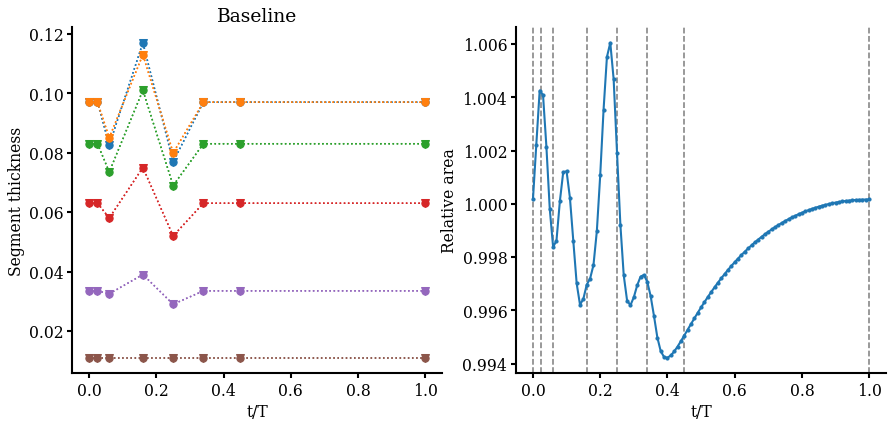

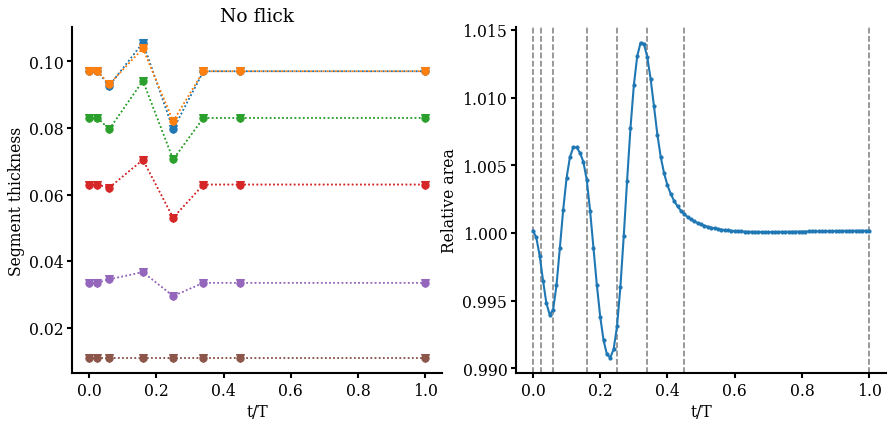

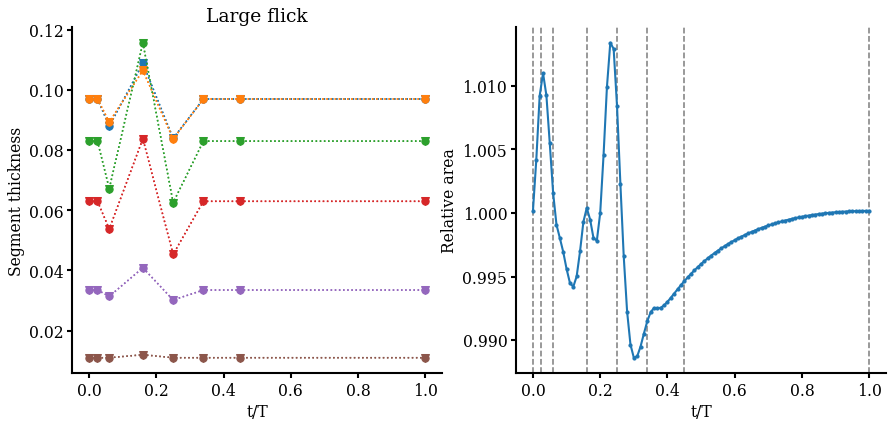

In [5]:
times = np.linspace(0, 1, 101)
areas = {}
areas_org = {}

for kin in kinematics:
    areas[kin] = []
    areas_org[kin] = []
    for t in times:
        # Get parameters for each control point.
        Lfit, thkFit, thetaFit = [], [], []
        thkFitOrg = []
        for j in range(kinematics[kin]["Nsegments"]):
            Lfit.append(utils.getSegmentPosition(j, t, kinematics[kin]["length"]))
            thkFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["thick"]))
            thkFitOrg.append(utils.getSegmentPosition(j, t, kinematics[kin]["thick_org"]))
            thetaFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["theta"]))

        xy, cps, area = utils.profileFromParams(Lfit, thkFit, thetaFit)
        xy, cps, area_org = utils.profileFromParams(Lfit, thkFitOrg, thetaFit)
        areas[kin] = np.append(areas[kin], area)
        areas_org[kin] = np.append(areas_org[kin], area_org)
    
    print(kin)
    print("  rms ", np.sqrt(np.sum((areas[kin] - Aref)**2. / len(areas[kin]))))
    print("  ms  ", (np.sum((areas[kin] - Aref)**2. / len(areas[kin]))))
    print("  mean", (np.sum(np.abs(areas[kin] - Aref) / len(areas[kin]))))
    
    fig, ax = niceFig("t/T", "Segment thickness", ncols=2, figsize=(14, 6))
    ax[0].set_title(kin)
    ax[1].set_ylabel("Relative area")
    for j in range(1, kinematics[kin]["thick"].shape[0]):
        ln = ax[0].plot(kinematics[kin]["thick"][0, :], kinematics[kin]["thick"][j, :], "o:", ms=7)[0]
        ax[0].plot(kinematics[kin]["thick_org"][0, :], kinematics[kin]["thick_org"][j, :], "v:", ms=7, c=ln.get_color())
    
    ln = ax[1].plot(times, areas[kin]/Aref, label=kin, lw=2)[0]
    ax[1].plot(times, areas_org[kin]/Aref, ".", lw=2, c=ln.get_color())
    ylim = ax[1].get_ylim()
    ax[1].vlines(kinematics[kin]["thick"][0, :], ylim[0], ylim[1], color="k", linestyle="--", alpha=0.5, zorder=-100)
    ax[1].set_ylim(ylim)

(0.0, 1.0)

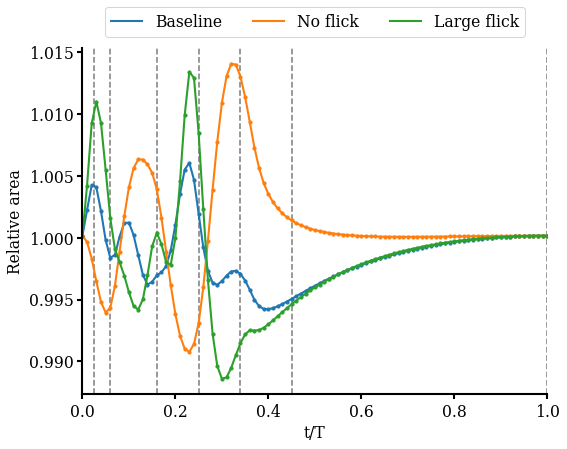

In [6]:
fig, ax = niceFig("t/T", "Relative area")
for kin in areas:
    ln = ax.plot(times, areas[kin]/Aref, label=kin, lw=2)[0]
    ax.plot(times, areas_org[kin]/Aref, ".", lw=2, c=ln.get_color())
ylim = ax.get_ylim()
ax.vlines(list(kinematics.values())[0]["thick"][0, :], ylim[0], ylim[1], color="k", linestyle="--", alpha=0.5, zorder=-100)
ax.set_ylim(ylim)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.01), ncols=3)
ax.set_xlim((0., 1))

In [7]:
for kin in kinematics:
    print(kin)
    for j in range(kinematics[kin]["Nsegments"]):
        vals = []
        for i in range(kinematics[kin]["thick"].shape[1]):
            if (i < 2) or (i > 4):
                vals.append(kinematics[kin]["thick_org"][1+j, i])
            else:
                vals.append(kinematics[kin]["thick"][1+j, i])
        print("[", ", ".join(["{:.6f}".format(v) for v in vals]), "],")

Baseline
[ 0.097000, 0.097000, 0.082523, 0.117000, 0.076917, 0.097000, 0.097000, 0.097000 ],
[ 0.097000, 0.097000, 0.085018, 0.113000, 0.079934, 0.097000, 0.097000, 0.097000 ],
[ 0.083000, 0.083000, 0.073513, 0.101000, 0.068950, 0.083000, 0.083000, 0.083000 ],
[ 0.063000, 0.063000, 0.058009, 0.075000, 0.051967, 0.063000, 0.063000, 0.063000 ],
[ 0.033500, 0.033500, 0.032505, 0.039000, 0.028984, 0.033500, 0.033500, 0.033500 ],
[ 0.011000, 0.011000, 0.011000, 0.011000, 0.011000, 0.011000, 0.011000, 0.011000 ],
No flick
[ 0.097000, 0.097000, 0.092676, 0.105580, 0.079560, 0.097000, 0.097000, 0.097000 ],
[ 0.097000, 0.097000, 0.093141, 0.103864, 0.082047, 0.097000, 0.097000, 0.097000 ],
[ 0.083000, 0.083000, 0.079606, 0.094149, 0.070536, 0.083000, 0.083000, 0.083000 ],
[ 0.063000, 0.063000, 0.062070, 0.070432, 0.053024, 0.063000, 0.063000, 0.063000 ],
[ 0.033500, 0.033500, 0.034536, 0.036716, 0.029512, 0.033500, 0.033500, 0.033500 ],
[ 0.011000, 0.011000, 0.011000, 0.011000, 0.011000, 0.0110

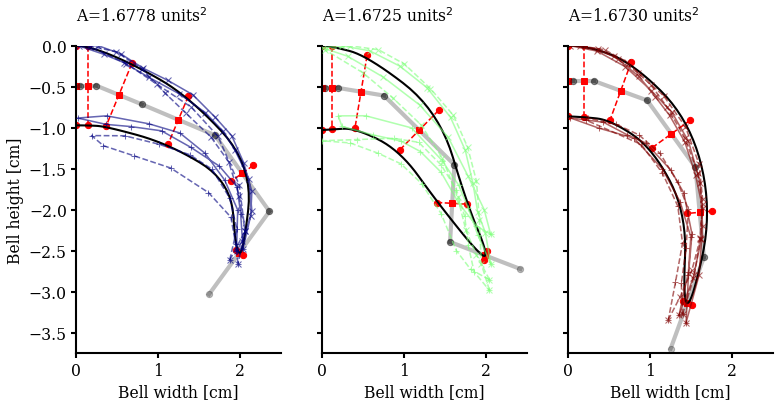

In [8]:
# From Costello 2020 fig 9
# Data contain three snapshots of two cycles. Upper and lower part of the medusa
# (aboral and subumbrellar surfaces) for each.
unitsToCm = 0.2
data_Costello = pandas.read_csv(os.path.join(
    projectDir, "dataset_01_medusae/deformedShapeHistory_Costello2020_fig9.csv"), header=None)
snapshotColoursCostello = plt.cm.jet(np.linspace(0, 1, 3))

fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True)
for ax in axes:
    makeNiceAxes(ax, "Bell width [cm]")
    ax.set_aspect("equal")
    ax.set_xlim((0, 0.5/unitsToCm))
    ax.set_ylim((-0.75/unitsToCm, 0.))
axes[0].set_ylabel("Bell height [cm]")

# Plot raw Costello data.
linestyles = ["-", "--"]
for j in range(2):
    for i in range(3):
        i0 = j*4*3+i*4
        # Retrieve the data from the ordered table.
        df = data_Costello[range(i0, i0+4)]
        df.columns = ["xl", "yl", "xu", "yu"]

        # Find the origin of each frame. Assumed at mid-width and top.
        x0 = (df["xu"].max() + df["xu"].min())/2.
        y0 = df["yu"].max()

        # Plot the data for each snapshot.
        axes[i].plot(np.abs(df["xl"]-x0) / unitsToCm, (df["yl"]-y0) / unitsToCm,
                     linestyles[j]+"+", alpha=0.6, zorder=100, c=snapshotColoursCostello[i])
        axes[i].plot(np.abs(df["xu"]-x0) / unitsToCm, (df["yu"]-y0) / unitsToCm,
                     linestyles[j]+"x", alpha=0.6, zorder=100, c=snapshotColoursCostello[i])

# Plot regressed shapes.
for i, t in enumerate([0, 0.13, 0.27]):
    kin = "Baseline"
    
    # Get parameters for each control point.
    Lfit, thkFit, thetaFit = [], [], []
    for j in range(kinematics[kin]["Nsegments"]):
        Lfit.append(utils.getSegmentPosition(j, t, kinematics[kin]["length"]))
        thkFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["thick"]))
        thetaFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["theta"]))

    # Compute and plot the profile.
    xy, cps, area = utils.profileFromParams(Lfit, thkFit, thetaFit, ax=axes[i],
                                            colour="k", scalePlot=1./unitsToCm)
    
    np.savetxt(os.path.join(projectDir, "dataset_01_medusae/shape_Costello2020_snapshot{:d}.txt".format(i+1)),
        np.hstack([xy, np.zeros((xy.shape[0], 1))]))

plt.savefig(os.path.join(projectDir, "outputs", "kinematicsModel.png"), dpi=200, bbox_inches="tight")

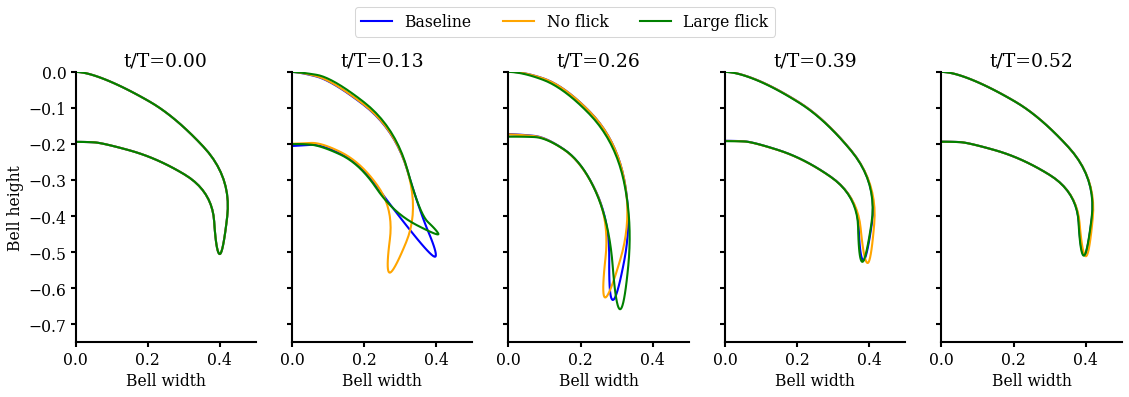

In [9]:
times = [0, 0.13, 0.26, 0.39, 0.52]
# times = [0.14, 0.18]

fig, axes = niceFig("Bell width", "", ncols=len(times), figsize=(18, 5.5))
axes[0].set_ylabel("Bell height")
for ax in axes:
    ax.set_aspect("equal")
    ax.set_xlim((0, 0.5))
    ax.set_ylim((-0.75, 0.))
for ax in axes[1:]:
    ax.set_yticklabels([])

colours = ["b", "orange", "g"]
for i, t in enumerate(times):
    lns = []
    axes[i].set_title("t/T={:.2f}".format(t))
    for iKin, kin in enumerate(kinematics):
        Lfit, thkFit, thetaFit = [], [], []
        for j in range(kinematics[kin]["Nsegments"]):
            Lfit.append(utils.getSegmentPosition(j, t, kinematics[kin]["length"]))
            thkFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["thick"]))
            thetaFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["theta"]))
        xy, cps, area = utils.profileFromParams(Lfit, thkFit, thetaFit)#,
            # colour=colours[iKin], ax=axes[i], scalePlot=1)
        lns += axes[i].plot(xy[:, 0], xy[:, 1], "-", lw=2, label=kin, c=colours[iKin])

fig.legend(lns, [l.get_label() for l in lns], loc="upper center", ncol=3)

plt.savefig(os.path.join(projectDir, "outputs", "kinematicsComparison.png"), dpi=200, bbox_inches="tight")

# Additional debugging of motion interpolation

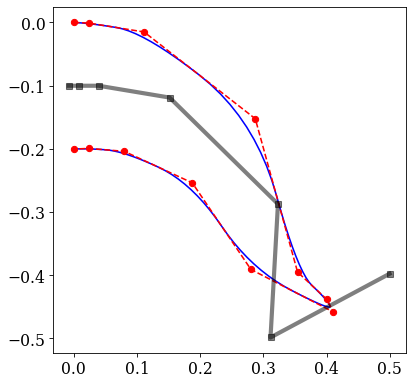

In [10]:
t = 0.13
kin = "Large flick"
    
# Get parameters for each control point.
Lfit, thkFit, thetaFit = [], [], []
for j in range(kinematics[kin]["Nsegments"]):
    Lfit.append(utils.getSegmentPosition(j, t, kinematics[kin]["length"]))
    thkFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["thick"]))
    thetaFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["theta"]))
    
def profileFromParams(length, halfThickness, theta, s=np.linspace(0, 1, 101),
                      ax=None, dxPlot=0, scalePlot=1., colour="b"):
    cps_u, cps_l = [], []

    xLast = np.array([-length[0]/2., -halfThickness[0]])
    backbonePts = [xLast]
    for i in range(len(halfThickness)):
        xNew = xLast + [length[i], 0.]
        xNew = utils.rotatePoint(xNew, xLast, -theta[i])
        backbonePts.append(xNew)
        xMid = (xLast + xNew) / 2.
        vTan = (xNew - xLast) / np.linalg.norm(xNew - xLast)
        vPer = np.array([-vTan[1], vTan[0]])

        p0 = xMid + halfThickness[i]*vPer
        p1 = xMid - halfThickness[i]*vPer
        cps_u.append(p0)
        cps_l.append(p1)

        if ax is not None:
            ax.plot([xLast[0]*scalePlot+dxPlot*scalePlot, xNew[0]*scalePlot+dxPlot*scalePlot],
                    [xLast[1]*scalePlot, xNew[1]*scalePlot], "ko-", lw=4, alpha=0.25)
            ax.plot(xMid[0]*scalePlot+dxPlot*scalePlot, xMid[1]*scalePlot, "rs")
            ax.plot([p0[0]*scalePlot+dxPlot*scalePlot, p1[0]*scalePlot+dxPlot*scalePlot],
                    [p0[1]*scalePlot, p1[1]*scalePlot], "r--")

        xLast = xNew

    cps = np.vstack([cps_u, np.flipud(cps_l)])
    xy = np.array([utils.bspline(cps, u, d=2) for u in s])
    area = utils.polyArea(xy[:, 0], xy[:, 1])

    if ax is not None:
        ax.plot(cps[:, 0]*scalePlot+dxPlot*scalePlot, cps[:, 1]*scalePlot, "ro")
        ax.plot(xy[:, 0]*scalePlot+dxPlot*scalePlot, xy[:, 1]*scalePlot, lw=2, c=colour)
        ax.text(dxPlot*scalePlot, 0.05*scalePlot, "A={:.4f} units$^2$".format(area*scalePlot**2.),
                va="bottom", ha="left")

    return xy, cps, area, np.array(backbonePts)

# Compute and plot the profile.
xy, cps, area, bkbn = profileFromParams(Lfit, thkFit, thetaFit)#, ax=ax)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.plot(xy[:, 0], xy[:, 1], "b-")
ax.plot(cps[:, 0], cps[:, 1], "ro--")
ax.plot(bkbn[:, 0], bkbn[:, 1], "ks-", lw=4, alpha=0.5)

np.savetxt(os.path.join(projectDir, "testData", "xy.txt"), xy)
np.savetxt(os.path.join(projectDir, "testData", "cps.txt"), cps)
np.savetxt(os.path.join(projectDir, "testData", "backbone.txt"), bkbn)

In [11]:
kinematics[kin]["theta"]

array([[ 0.   ,  0.025,  0.15 ,  0.25 ,  0.35 ,  0.45 ,  1.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.39 ,  0.39 ,  0.   ,  0.38 ,  0.39 ,  0.39 ,  0.39 ],
       [ 0.4  ,  0.4  ,  0.85 ,  1.2  ,  0.41 ,  0.4  ,  0.4  ],
       [ 0.95 ,  0.95 ,  1.95 ,  1.65 ,  0.95 ,  0.95 ,  0.95 ],
       [ 2.2  ,  2.2  , -2.5  ,  2.19 ,  2.2  ,  2.2  ,  2.2  ]])

In [12]:
thetaFit

[0.0,
 0.0,
 0.1653062941338843,
 0.7765174095049809,
 1.6264244749426866,
 -0.4914123968472613]

In [13]:
iSeg = 5
sx = 0.5
# Pick control points from the array and make a spline
cps_y = kinematics[kin]["theta"][[0, iSeg+1], :]
#t, y = old_evaluate_spline(cps_y, [sx])
t, y = utils.bspline(cps_y.T, sx)
print(cps_y)
print(t, y)

[[ 0.     0.025  0.15   0.25   0.35   0.45   1.   ]
 [ 2.2    2.2   -2.5    2.19   2.2    2.2    2.2  ]]
0.24999999999999997 1.4100000000000001


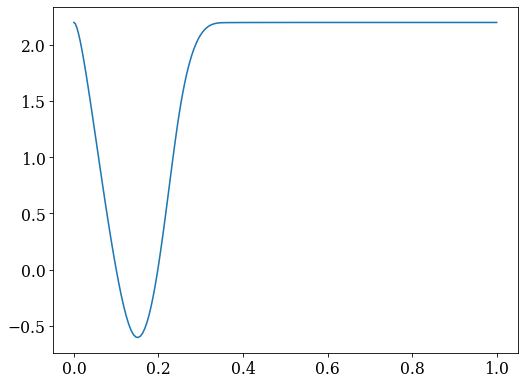

In [14]:
s = np.arange(0, 1.001, 0.01)
y = []
for sx in s:
    y.append(utils.bspline(cps_y.T, sx))
y = np.array(y)
plt.plot(y[:, 0], y[:, 1])
np.savetxt(os.path.join(projectDir, "testData", "segSpline.txt"), y)

In [15]:
# regressedShapes = []
# for i in range(3):
#     regressedShapes.append(np.loadtxt(
#         os.path.join(projectDir, "dataset_01_medusae/shape_Costello2020_snapshot{:d}.txt".format(i+1))))

# figs, axes = [], []
# for i in range(len(regressedShapes)):
#     fig, ax = niceFig("Bell width", "Bell height")
#     ax.set_aspect("equal")
#     ax.set_xlim((0, 0.5))
#     ax.set_ylim((-0.75, 0.))
#     # ax.plot(regressedShapes[i][:, 0]-i*0.5, regressedShapes[i][:, 1], "k--", lw=2, label="Costello et al.")
#     axes.append(ax)
#     figs.append(fig)

# for i, t in enumerate([0, 0.13, 0.27]):
#     for kin in kinematics:
#         # Get parameters for each control point.
#         Lfit, thkFit, thetaFit = [], [], []
#         for j in range(kinematics[kin]["Nsegments"]):
#             Lfit.append(utils.getSegmentPosition(j, t, kinematics[kin]["length"]))
#             thkFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["thick"]))
#             thetaFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["theta"]))

#         # Compute and plot the profile.
#         xy, cps, area = utils.profileFromParams(Lfit, thkFit, thetaFit)
#         axes[i].plot(xy[:, 0], xy[:, 1], "-", lw=2, label=kin)

# for ax in axes:
#     ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.01))

# More

In [16]:
# # Compute velocity on the profile using finite differences.
# Lscale = 1.
# dt = 0.001
# times = np.arange(0, 1+dt/2, dt)
# profiles = {}
# for kin in kinematics:
#     profiles[kin] = []
#     for i, t in enumerate(times):
#         Lfit, thkFit, thetaFit = [], [], []
#         for j in range(kinematics[kin]["Nsegments"]):
#             Lfit.append(utils.getSegmentPosition(j, t, kinematics[kin]["length"]))
#             thkFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["thick"]))
#             thetaFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["theta"]))
#         xy, cps, area = utils.profileFromParams(Lfit, thkFit, thetaFit, s=np.linspace(0, 1, 101))
#         profiles[kin].append(xy*Lscale)

# tipVel = {}
# maxVel = {}
# for kin in kinematics:
#     tipVel[kin] = []
#     maxVel[kin] = []
#     for i in range(1, len(profiles[kin])):
#         u = np.linalg.norm(profiles[kin][i] - profiles[kin][i-1], axis=1) / dt
#         tipVel[kin].append(u[u.shape[0]//2])
#         maxVel[kin].append(np.max(u))

In [17]:
# fig, ax = niceFig("t/T", "Tip surface velocity")
# for kin in kinematics:
#     # ax.plot(times[1:], maxVel, "r-", lw=2, label="Max")
#     ax.plot(times[1:], np.array(tipVel[kin]), "-", lw=2, label=kin)
# ax.legend()
# ax.set_xlim((0, 1))
# # ax.set_ylim((0, 4))

In [18]:
#Umax = np.max(maxVel["Large flick"])
Umax = 3.42

# Validation data from Costello et al.

In [19]:
# %% Read time series data of Costello
ref_Uswim = np.loadtxt(os.path.join(projectDir, "dataset_01_medusae/data_Costello2020_Uswim.txt"))
ref_Uedge = np.loadtxt(os.path.join(projectDir, "dataset_01_medusae/data_Costello2020_Uedge.txt"))
ref_dist = np.loadtxt(os.path.join(projectDir, "dataset_01_medusae/data_Costello2020_totalDistance.txt"))
ref_fin = np.loadtxt(os.path.join(projectDir, "dataset_01_medusae/data_Costello2020_fineness.txt"))

# From the plot by Costello.
tVals = np.array([0.04836558, 0.22848566, 0.41027352, 1.39926618, 1.57771848, 1.76617745])

In [20]:
period = tVals[3:] - tVals[:3]
print(period)
period = np.mean(period)  # s

[1.3509006  1.34923282 1.35590393]


In [21]:
Linf = 0.04  # m

In [22]:
Uinf = Umax*Linf/period
print(Uinf)

0.10118250020552697


In [23]:
Uswim = 0.02  # m/s
Re = Linf*Uswim/1e-6
print(Re)

800.0000000000001


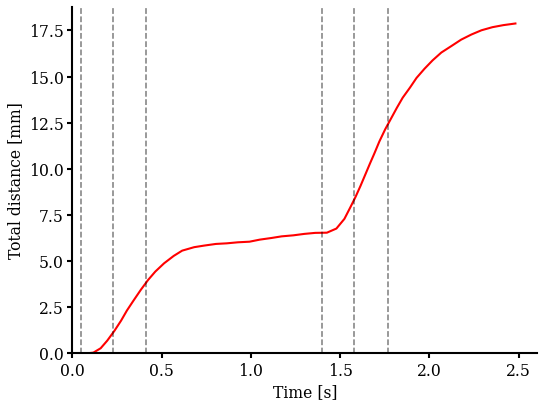

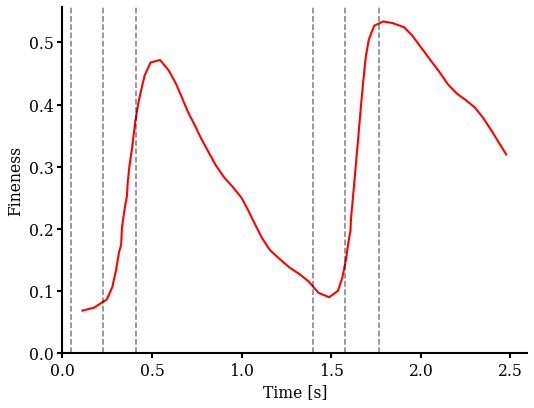

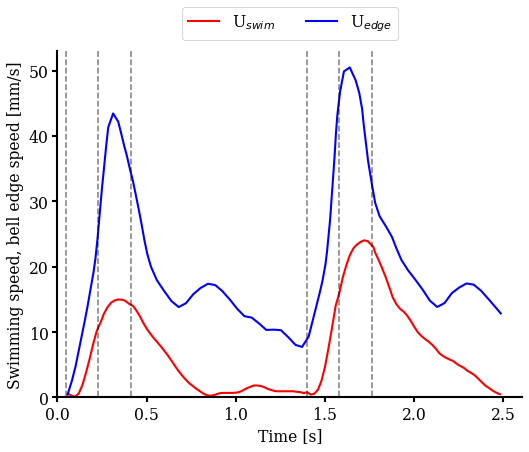

In [24]:
fig, ax = niceFig("Time [s]", "Total distance [mm]")
ax.plot(ref_dist[:, 0], ref_dist[:, 1], "r-", lw=2)
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_xlim(0, ax.get_xlim()[1])
ax.vlines(tVals, ylim[0], ylim[1], linestyle="dashed", color="k", alpha=0.5)

fig, ax = niceFig("Time [s]", "Fineness")
ax.plot(ref_fin[:, 0], ref_fin[:, 1], "r-", lw=2)
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_xlim(0, ax.get_xlim()[1])
ax.vlines(tVals, 0, ylim[1], linestyle="dashed", color="k", alpha=0.5)

fig, ax = niceFig("Time [s]", "Swimming speed, bell edge speed [mm/s]")
ax.plot(ref_Uswim[:, 0], ref_Uswim[:, 1], "r-", lw=2, label="U$_{swim}$")
ax.plot(ref_Uedge[:, 0], ref_Uedge[:, 1], "b-", lw=2, label="U$_{edge}$")
ax.legend(ncol=2, bbox_to_anchor=(0.5, 1.01), loc="lower center")
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_xlim(0, ax.get_xlim()[1])
ax.vlines(tVals, ylim[0], ylim[1], linestyle="dashed", color="k", alpha=0.5)

# Compute the period in second, non-dimensionalise snapshot times to range (0, 1).
tVals /= period
tVals -= tVals[0]

# Check initial simulations

In [5]:
# cases = ["baseline", "noFlick", "largeFlick"]
# labs = ["Baseline", "No flick", "Large flick"]

#cases = ["largeFlick_pTol_1e-2", "largeFlick", "largeFlick_pTol_1e-6", "largeFlick_pTol_1e-7"]
#labs = ["Large flick pTol=1e-2", "Large flick pTol=1e-5", "Large flick pTol=1e-6", "Large flick pTol=1e-7"]

# cases = ["largeFlick"]
# labs = ["largeFlick"]

cases = [
    # "baseline_B-S_smallDomain", "baseline", "baseline_noB-S",
    "baseline_noB-S_12x12dom_N64",
    "baseline_B-S_12x12dom_N64"]

labs = [
    # "B-S, small dom.", "B-S, large dom.", "No B-S, large dom.",
        "No B-S, v. large dom., N/L=64",
       "B-S, v. large dom., N/L=64"]

data = {}
for iCase, case in enumerate(cases):
    try:
        data[case] = pandas.read_csv(os.path.join(projectDir, "outputs", "timeHistory_{}_Re_500.0.csv".format(case)),
                             names=["dt", "t", "fx", "fy", "ext1", "ext2", "isnan", "isfin"])
    except FileNotFoundError:
        pass

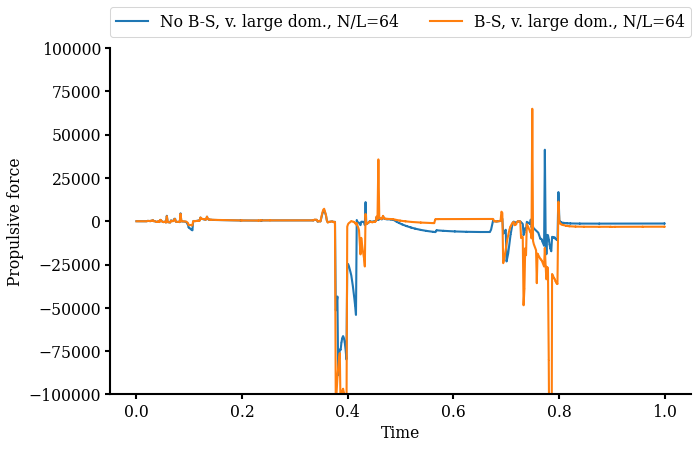

In [6]:
fig, ax = niceFig("Time", "Propulsive force", figsize=(10, 6))
# ax.set_xlim((0, 20))
ax.set_ylim((-1e5, 1e5))
for iCase, case in enumerate(cases):
    try:
        df = data[case]
        ax.plot(df["t"]/df["t"].max(), df["fx"], "-", lw=2, label=labs[iCase])
    except FileNotFoundError:
        pass
ax.legend(ncol=2, loc="lower center", bbox_to_anchor=(0.5, 1.01))
# plt.savefig(os.path.join(projectDir, "outputs", "forceComparison.png"), dpi=200)

In [8]:
32+32+45+90+190+25+25+52+20

511